In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from petsc4py.PETSc import ScalarType
from mpi4py import MPI
from dolfinx import mesh, fem
from dolfinx.mesh import CellType, locate_entities_boundary
from dolfinx.fem import Function, dirichletbc, locate_dofs_topological
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, set_bc
import ufl
from petsc4py import PETSc
from preprocess_gpu import clear_gpu

clear_gpu()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

All GPU variables in globals() have been deleted and GPU memory has been cleared.
GPU Memory Information (Device 0):
  Total Memory: 11264.00 MB
  Used Memory : 467.31 MB
  Free Memory : 10796.69 MB
Using device: cuda


## Equation and problem definition

For a domain $\Omega \subset \mathbb{R}^n$ with boundary $\partial \Omega = \Gamma_D \cup \Gamma_N$, the Poisson equation with particular boundary conditions reads:

$$
\begin{aligned}
- \nabla^2 u &= f \quad \text{in } \Omega, \\
u &= 0 \quad \text{on } \Gamma_D, \\
\end{aligned}
$$

where $f$ input data   
The variational problem reads: find $u \in V$ such that
$$
a(u, v) = L(v) \quad \forall v \in V,
$$

where $V$ is a suitable function space and

$$
\begin{aligned}
a(u, v) &:= \int_\Omega \nabla u \cdot \nabla v \, dx \\
L(v) &:= \int_\Omega f v \, dx 
\end{aligned}
$$

The expression $a(u, v)$ is the bilinear form and $L(v)$ is the linear form.  
It is assumed that all functions in $V$ satisfy the Dirichlet boundary conditions ($u = 0$ on $\Gamma_D$).

In this demo we consider:

- $\Omega = [0, 1] \times [0, 1]$ (a rectangle)  
- $\Gamma_D = \{ (0, y) \} \cup \{ (1, y) \} \subset \partial \Omega$  
- $f = m_0sin(n_0x + n_1y) + m_1cos(n_2x + n_3y),  \quad m_0,m_1,n_0,n_1,n_2,n_3 \in R$ 
---



#### Using DOLPHINX to generate mesh and compute stiffness matrix $A:= a(u,v)$ and vector $F:=L(v)$

In [ ]:

# ============================================================================
# 1. Data Generation with DOLFINx 

num_samples = 1
nx, ny = 30, 30   # divisions in x and y

# ---------------------------
# ---------------------------
# ---------------------------

domain = mesh.create_rectangle(
    comm=MPI.COMM_WORLD,
    points=((0.0, 0.0), (1.0, 1.0)),
    n=(nx, ny),
    cell_type=CellType.triangle
)
# Extract Mesh Geometry and Connectivity Info
# ---------------------------
V = fem.functionspace(domain, ("Lagrange", 1))

ng = domain.geometry.x.shape[0]
ne = domain.topology.index_map(domain.topology.dim).size_local

# Use quadratic (P2) Lagrange elements for the PDE.
# Create a linear (P1) space for projection (for CNN training & visualization).


# Locate boundary facets for Dirichlet BC: u = 0 on the boundary.
# boundary_facets = locate_entities_boundary(
#     domain, dim=1,
#     marker=lambda x: np.logical_or(
#         np.isclose(x[0], 0.0) | np.isclose(x[0], 1.0),
#         np.isclose(x[1], 0.0) | np.isclose(x[1], 1.0)
#     )
# )
boundary_facets = locate_entities_boundary(
    domain, dim=1,
    marker=lambda x: np.isclose(x[0], 0.0) | np.isclose(x[0], 1.0))

boundary_dofs = locate_dofs_topological(V, entity_dim=1, entities=boundary_facets)


bc = dirichletbc(ScalarType(0.0), boundary_dofs, V)

# Define variational problem for the Poisson equation on V2:
u_trial = ufl.TrialFunction(V)
v_test = ufl.TestFunction(V)
a = ufl.inner(ufl.grad(u_trial), ufl.grad(v_test)) * ufl.dx

# f_fun will be defined by interpolating a symbolic expression.
f_fun = Function(V)
L = ufl.inner(f_fun, v_test) * ufl.dx

# Assemble stiffness matrix for the quadratic space (V2).
a_form = fem.form(a)
A = assemble_matrix(a_form, bcs=[bc])
A.assemble()

# Prepare the load vector form.
L_form = fem.form(L)

# Create a direct solver (LU) for A2 u = F.
solver = PETSc.KSP().create(MPI.COMM_WORLD)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)


# For plotting, the number of vertices in V1 (structured grid) is:
num_vertices = (nx+1) * (ny+1)


F_samples = []  # inputs: load vectors projected to P1 (as images)
u_samples = []  # targets: FEM solutions projected to P1

uh = Function(V)   # quadratic solution (in V2)

# ============================================================================
# 2. Prepare the Physics Loss and Convert A1 (P1 stiffness) to a PyTorch Tensor
# ============================================================================
import scipy.sparse
# Assemble stiffness matrix for V1 was computed as A1.
ia1, ja1, a1_vals = A.getValuesCSR()
A_stiff = scipy.sparse.csr_matrix((a1_vals, ja1, ia1), shape=A.getSize()).toarray() # shape: (num_vertices, num_vertices)
print("DOLFINx: Generated A matrix with shapes:", A_stiff.shape)

def generate_train_sample():
    for i in range(num_samples):
        # Define forcing function f symbolically with random parameters.
        
        m0, m1 = 1 + np.random.rand(2)
        n0, n1, n2, n3 = np.pi * np.random.rand(4)
        x = ufl.SpatialCoordinate(domain)

            # The lambda captures the random parameters.

        f_fun.interpolate(lambda x, m0=m0, m1=m1, n0=n0, n1=n1, n2=n2, n3=n3: 
                            m0 * np.sin(n0*x[0] + n1*x[1]) + m1 * np.cos(n2*x[0] + n3*x[1]))
        
        # Assemble the load vector F in V2.
        F_vec = assemble_vector(L_form)
        apply_lifting(F_vec, [a_form], [[bc]])
        F_vec.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        set_bc(F_vec, [bc])
        
        # Solve the quadratic system A2 u = F.
        solver.solve(F_vec, uh.x.petsc_vec)
        uh.x.scatter_forward()

        # Extract arrays and reshape them into (num_y, num_x) grids.
        u_vals = uh.x.array[:]
        F_vals = F_vec.array[:]  # assembled load vector F
        # Extract the vertex values from the projection (V1).
        u_image = u_vals.reshape((u_vals.shape[0],1))

        F_image = F_vals.reshape((F_vals.shape[0],1))
        
        F_samples.append(F_image)
        u_samples.append(u_image)

    F_samples = np.array(F_samples)  # shape: (num_samples, ny+1, nx+1)
    u_samples = np.array(u_samples)  # shape: (num_samples, ny+1, nx+1)
    print("DOLFINx: Generated training data with shapes:", F_samples.shape, u_samples.shape)
    return F_samples,u_samples

def generate_test_sample():
    # np.random.seed(0)
    m0, m1 = [2,3]
    n0, n1, n2, n3 = np.pi * np.array([3, 1, 2, 3])
   
    x = ufl.SpatialCoordinate(domain)

    f_fun.interpolate(lambda x, m0=m0, m1=m1, n0=n0, n1=n1, n2=n2, n3=n3:
                        m0 * np.sin(n0*x[0] + n1*x[1]) + m1 * np.cos(n2*x[0] + n3*x[1]))
    
    F_vec = assemble_vector(L_form)
    apply_lifting(F_vec, [a_form], [[bc]])
    F_vec.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    set_bc(F_vec, [bc])
    
    solver.solve(F_vec, uh.x.petsc_vec)
    uh.x.scatter_forward()
    # Extract arrays and reshape them into (num_y, num_x) grids.
    u_vals = uh.x.array[:]
    F_vals = F_vec.array[:]  # assembled load vector F
    # Extract the vertex values from the projection (V1).
    u_test = u_vals.reshape((u_vals.shape[0],1))
    F_test = F_vals.reshape((F_vals.shape[0],1))
    return F_test, u_test, uh

def normalize_input(tensor):
    """
    Normalize the input tensor (assumed shape (batch, 1, n))
    using the mean and std computed over the batch and spatial dimensions.
    (For production, use statistics computed over the full training set.)
    Returns: normalized_tensor, mean, std.
    """
    mean = tensor.mean(dim=[0, 1], keepdim=True)  # shape: (1, 1, 1)
    std = tensor.std(dim=[0,1], keepdim=True) + 1e-6
    return (tensor - mean) / std, mean, std

def denormalize_output(tensor, mean, std):
    """Reverse the normalization: tensor * std + mean."""
    return tensor * std + mean


# ============================================
# Generate sameple 
#============================================
F_test_image, u_test_image, uh = generate_test_sample() # (n,1)
F_test_tensor = torch.tensor(F_test_image).float().unsqueeze(0) #(1,n,1)
u_test_tensor = torch.tensor(u_test_image).float().unsqueeze(0) #(1,n,1)
A_stiff_tensor = torch.tensor(A_stiff, dtype=torch.float) # Duplicate and Reshape input to (dim, dim)

DOLFINx: Generated A matrix with shapes: (961, 961)


In [3]:
# # def normalize_with_pandas(x):
# #     """
# #     Normalize a tensor using pandas functions.
# #     x: Input tensor with shape (batch, 1, n). Expected to be on CPU.
    
# #     Returns:
# #       - normalized tensor with shape (batch, 1, n),
# #       - mean (as a pandas Series) computed column-wise,
# #       - std (as a pandas Series) computed column-wise.
# #     """
# #     # Remove the channel dimension: result shape (batch, n)
# #     x_cpu = x.detach().cpu().squeeze(1)
# #     # Convert the tensor to a pandas DataFrame.
# #     df = pd.DataFrame(x_cpu.numpy())
    
# #     # Compute the column-wise mean and std. (axis=0: compute for each column)
# #     mean = df.mean(axis=0)
# #     std = df.std(axis=0)
    
# #     # Normalize the DataFrame
# #     df_norm = (df - mean) / std
# #     # Convert back to a tensor and restore the channel dimension.
# #     x_norm = torch.tensor(df_norm.values, dtype=x.dtype)
# #     x_norm = x_norm.unsqueeze(1)  # Shape: (batch, 1, n)
# #     return x_norm, mean, std

# # def denormalize_with_pandas(x_norm, mean, std):
#     """
#     Denormalize a tensor using pandas functions.
#     x_norm: Normalized tensor with shape (batch, 1, n), assumed to be on CPU.
#     mean, std: pandas Series computed during normalization.
    
#     Returns:
#       - Denormalized tensor with shape (batch, 1, n)
#     """
#     x_cpu = x_norm.detach().cpu().squeeze(1)  # Shape: (batch, n)
#     df = pd.DataFrame(x_cpu.numpy())
    
#     # Reverse normalization: multiply by std then add mean.
#     df_denorm = df * std + mean
#     x_denorm = torch.tensor(df_denorm.values, dtype=x_norm.dtype)
#     x_denorm = x_denorm.unsqueeze(1)  # Shape: (batch, 1, n)
#     return x_denorm

### Initial setting

In [4]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import pandas as pd
import os
val_ratio = 0.2          # Fraction of samples for validation\
batch_ratio =0.5 
num_epochs = 100000 
batch_size = int(batch_ratio*num_samples )    # Batch size for training
learning_rate = 1e-3     # Learning rate
dim = A_stiff.shape[0]       # Dimension of matrix A and vectors b and u (can be any positive integer)


# F_sample_tensor = torch.tensor(F_samples, dtype=torch.float) #    (batch, length=dim,1 )
# u_sample_tensor = torch.tensor(u_samples, dtype=torch.float)#    (batch, length=dim,1)
# full_dataset = TensorDataset(F_sample_tensor, u_sample_tensor)

# # Split dataset into training and validation portions.
# val_size = int(val_ratio * num_samples)
# train_size = num_samples - val_size

# train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
# train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
# val_loader   = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)


### Train Model

In [5]:
# from CNN_FC_Net import HybridCNN_FC_2
# from CNNModel import CNNModel1
# from ExtendedCNNVector import ExtendedCNNVector
n = F_test_image.shape[0]
print(n)
class HybridCNN_FC_2D(nn.Module):
    def __init__(self, n, dropout_prob=0.5):
        """
        Args:
           n: Dimension of the vector (so A is (n, n) and F, U are (1, n)).
           dropout_prob: Dropout probability for regularization.
        
        This model expects an input tensor of shape (batch, 1, n)
        and produces an output tensor of shape (batch, 1, n).
        InstanceNorm1d is used so that training with batch size 1 is stable.
        """
        super(HybridCNN_FC_2D, self).__init__()
        self.n = n

        # --- CNN part ---
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.in1   = nn.InstanceNorm1d(16, affine=True)
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.in2   = nn.InstanceNorm1d(32, affine=True)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)  # reduces length by factor of 2
        
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.in3   = nn.InstanceNorm1d(64, affine=True)
        # Use a second pooling layer to achieve an overall reduction factor of 4.
        self.pool1_2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.dropout = nn.Dropout(dropout_prob)
        # After two poolings, the length is reduced from n to n/4.
        self.fc_in_features = 64 * (n // 4)
        self.fc1 = nn.Linear(self.fc_in_features, 1024)
        self.fc2 = nn.Linear(1024, n)  # final FC outputs a vector of length n

    def forward(self, x):
        # x shape: (batch, 1, n)
        x = x.permute(0,2,1)
        x = F.relu(self.in1(self.conv1(x)))    # -> (batch, 16, n)
        x = self.pool1(x)                      # -> (batch, 16, n/2)
        x = F.relu(self.in2(self.conv2(x)))    # -> (batch, 32, n/2)
        x = self.pool1_2(x)                    # -> (batch, 32, n/4)
        x = F.relu(self.in3(self.conv3(x)))    # -> (batch, 64, n/4)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)              # flatten to (batch, 64*(n/4))
        x = F.relu(self.fc1(x))                # -> (batch, 1024)
        x = self.fc2(x)                        # -> (batch, n)
        x = x.unsqueeze(1)                     # -> (batch, 1, n)
        x = x.permute(0,2,1)
        return x
    
def physics_loss(A, U_pred, F_true):
    """
    Compute the physics loss to enforce A.U ≈ F.
    
    Args:
      A: Fixed matrix of shape (n, n).
      U_pred: Predicted vector of shape (1, n, 1).
      F_true: True vector of shape (1, n, 1).
      
    Returns:
      Loss computed as the MSE between A @ U and F.
    """
    A = A.to(U_pred.device)
    F_true_mat = F_true.squeeze(0)#(n,1)
    U_pred_mat = U_pred.squeeze(0)#(n,1)
    # For each sample, compute physics prediction: A @ U_pred.
    physics_pred = torch.matmul(A, U_pred_mat)  # shape: (n,1)
    loss = F.mse_loss(physics_pred, F_true_mat)
    return loss 
   
model = HybridCNN_FC_2D(n).to(device)

# Initialize the model and move it to the GPU if available.
# KAIMING INITIALIZATION
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        torch.nn.init.kaiming_normal_(m.weight.data)
        torch.nn.init.zeros_(m.bias)

model.apply(weights_init)
# ----------------------------
# 5. Set Up the Optimizer and Loss Functions
# ----------------------------
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_log = {
    "epoch": [],
    "train_total_loss": [],
    "train_data_loss": [],
    "train_physics_loss": [],
    "val_total_loss": [],
}

weight_factor = 0.5
# weight_factor = weight_factor.to(device)

# Normalize input F
    # Normalize F.
    
F_norm, f_mean, f_std = normalize_input(F_test_tensor)
u_norm, u_mean, u_std = normalize_input(u_test_tensor)

F_norm = F_norm.to(device)
f_mean = f_mean.to(device)
f_std = f_std.to(device)
new_epoch = 100000
for epoch in range(1, new_epoch ):
    model.train()
    optimizer.zero_grad()
    U_pred = model(F_norm)   # predicted U of shape (1, n, 1)
    U_pred_denorm = denormalize_output(U_pred, f_mean, f_std)

    loss = physics_loss(A_stiff_tensor, U_pred_denorm, F_test_tensor.to(device))/f_std*100
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        U_pred_final = model(F_norm)
    # Optionally, denormalize the predicted U.
        Val_loss = F.mse_loss(U_pred_denorm,u_test_tensor.to(device))/u_std.to(device)*100

    if epoch%500==0:
        print(f"Epoch {epoch}/{new_epoch} -- Physics Loss: {loss.item():.2e}| -- Val loss: {Val_loss.item():.2e}")

# Inference: After training, predict U for the same input F.
model.eval()
with torch.no_grad():
    U_pred_final = model(F_norm)
    # Optionally, denormalize the predicted U.
    U_pred_denorm = denormalize_output(U_pred_final, f_mean, f_std)
    data_error = F.mse_loss(U_pred_denorm,u_test_tensor.to(device)).item()
    print("Final predicted U shape:", U_pred_denorm.shape)



961
Epoch 100/100000 -- Physics Loss: 2.55e-01| -- Val loss: 2.93e+00
Epoch 200/100000 -- Physics Loss: 2.52e-01| -- Val loss: 2.93e+00
Epoch 300/100000 -- Physics Loss: 2.50e-01| -- Val loss: 2.93e+00
Epoch 400/100000 -- Physics Loss: 2.48e-01| -- Val loss: 2.93e+00
Epoch 500/100000 -- Physics Loss: 2.45e-01| -- Val loss: 2.92e+00
Epoch 600/100000 -- Physics Loss: 2.43e-01| -- Val loss: 2.92e+00
Epoch 700/100000 -- Physics Loss: 2.41e-01| -- Val loss: 2.92e+00
Epoch 800/100000 -- Physics Loss: 2.39e-01| -- Val loss: 2.91e+00
Epoch 900/100000 -- Physics Loss: 2.37e-01| -- Val loss: 2.91e+00
Epoch 1000/100000 -- Physics Loss: 2.35e-01| -- Val loss: 2.91e+00
Epoch 1100/100000 -- Physics Loss: 2.33e-01| -- Val loss: 2.90e+00
Epoch 1200/100000 -- Physics Loss: 2.31e-01| -- Val loss: 2.90e+00
Epoch 1300/100000 -- Physics Loss: 2.29e-01| -- Val loss: 2.89e+00
Epoch 1400/100000 -- Physics Loss: 2.27e-01| -- Val loss: 2.89e+00
Epoch 1500/100000 -- Physics Loss: 2.24e-01| -- Val loss: 2.88e+00


In [6]:
# ----------------------------
# 8. Export Loss Data to CSV
# ----------------------------
# df = pd.DataFrame(loss_log)
# csv_filename = "loss_data.csv"
# df.to_csv(csv_filename, index=False)
# print(f"Loss data saved to {os.path.abspath(csv_filename)}")

In [7]:

# ============================================================================
# 4. Evaluation on a New Test Sample and Plotting CNN Results

data_error = F.mse_loss(U_pred_denorm,u_test_tensor.to(device)).item()

print(f"Test Physics loss (RMSE of A*u_pred - F): {loss.item():.2e}")
print(f"Test Data loss (MSE of u_pred - u_true): {data_error:.2e}")


Test Physics loss (RMSE of A*u_pred - F): 6.49e-10
Test Data loss (MSE of u_pred - u_true): 9.87e-12


In [8]:
# from  post_processing import post_process_result

# print (F_test_image.shape,u_test_image.shape,U_pred_denorm_cpu.shape)

# mesh_coords, cells = post_process_result(domain,F_test_image,u_true_image,u_pred_image = U_pred_denorm_cpu)

### Visualize Solution

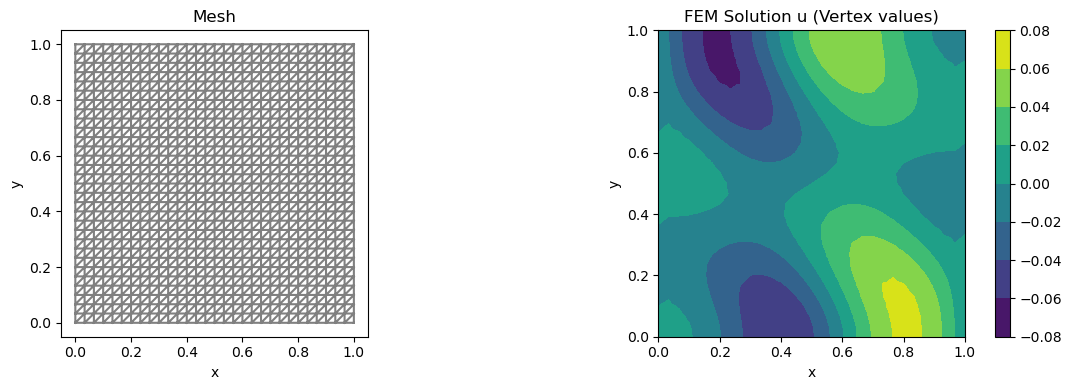

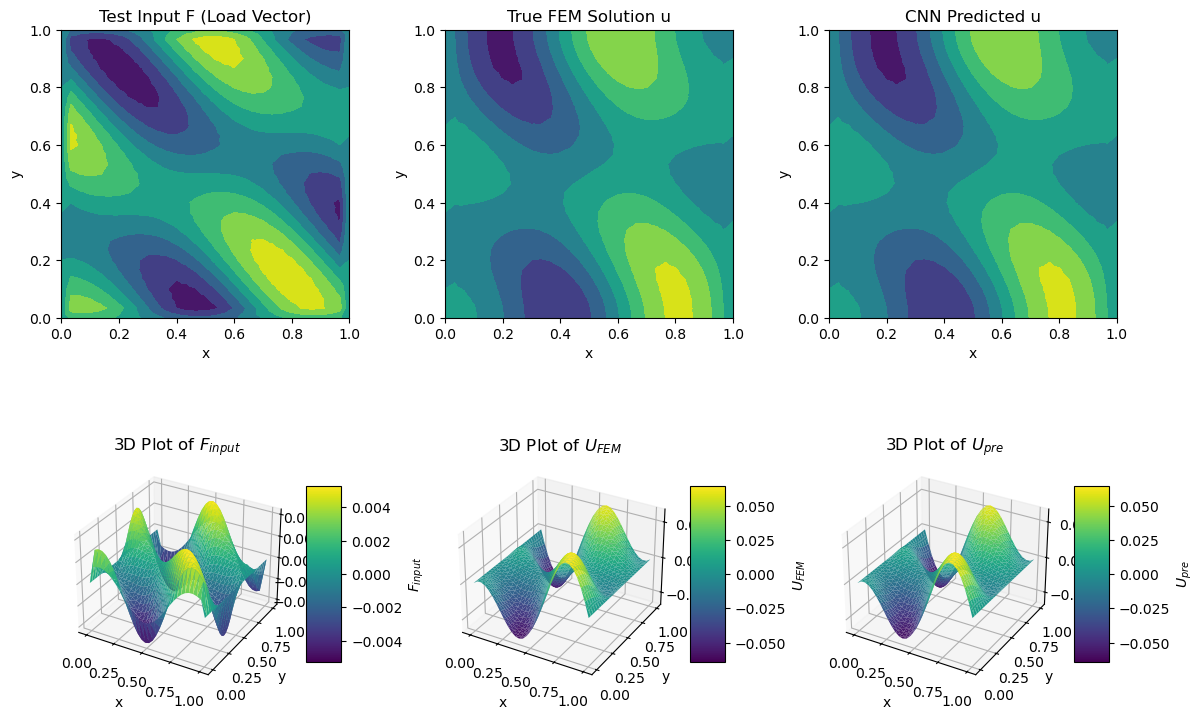

In [9]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri

U_pred_denorm_cpu = U_pred_denorm.cpu().squeeze(0).detach().numpy()

domain = domain
F_test_image = F_test_image 
u_test_image =u_test_image 

loss_log = None
log_range_start = 500 
log_range_end=-1

mesh_coords = domain.geometry.x  # shape (num_vertices_total, 2)

# Create cell connectivity (triangles) from the mesh topology.
domain.topology.create_connectivity(domain.topology.dim, 0)
cells = domain.topology.connectivity(domain.topology.dim, 0).array.reshape(-1, 3)

triangulation = tri.Triangulation(mesh_coords[:, 0], mesh_coords[:, 1], triangles=cells)
# Construct 
# Create an interpolator of the continuous solution
# LinearNDInterpolator uses the natural finite element interpolation
from scipy.interpolate import LinearNDInterpolator
u_interp = LinearNDInterpolator(mesh_coords[:,:2], U_pred_denorm_cpu)
u_inter_image = u_interp(mesh_coords[:,:2])
u_pred_image= u_inter_image
# -----------------------------

# Figure 1: Mesh and FEM solution plots
fig1 = plt.figure(figsize=(12, 4))

# Mesh subplot
ax_mesh = fig1.add_subplot(1, 2, 1)
ax_mesh.triplot(triangulation, color='gray')
ax_mesh.set_title("Mesh")
ax_mesh.set_xlabel("x")
ax_mesh.set_ylabel("y")
ax_mesh.set_aspect("equal")

# FEM solution subplot
ax_fem = fig1.add_subplot(1, 2, 2)
contour_fem = ax_fem.tricontourf(triangulation, u_test_image[:, 0], cmap='viridis')
fig1.colorbar(contour_fem, ax=ax_fem)
ax_fem.set_title("FEM Solution u (Vertex values)")
ax_fem.set_xlabel("x")
ax_fem.set_ylabel("y")
ax_fem.set_aspect("equal")

fig1.tight_layout()
plt.show()

# -----------------------------
# Figure 2: 2D contour and 3D surface plots
fig2 = plt.figure(figsize=(12, 8))

# First row: 2D contour plots
ax1 = fig2.add_subplot(2, 3, 1)
contour1 = ax1.tricontourf(triangulation, F_test_image[:, 0], cmap='viridis')
ax1.set_title("Test Input F (Load Vector)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_aspect("equal")

ax2 = fig2.add_subplot(2, 3, 2)
contour2 = ax2.tricontourf(triangulation, u_test_image[:, 0], cmap='viridis')
ax2.set_title("True FEM Solution u")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_aspect("equal")

# Only create the predicted contour if u_pred_image exists.
if u_pred_image is not None:
    ax3 = fig2.add_subplot(2, 3, 3)
    contour3 = ax3.tricontourf(triangulation, u_pred_image[:, 0], cmap='viridis')
    ax3.set_title("CNN Predicted u")
    ax3.set_xlabel("x")
    ax3.set_ylabel("y")
    ax3.set_aspect("equal")

# Second row: 3D surface plots
ax4 = fig2.add_subplot(2, 3, 4, projection='3d')
surf1 = ax4.plot_trisurf(triangulation, F_test_image[:, 0], cmap='viridis', edgecolor='none')
ax4.set_title("3D Plot of $F_{input}$")
ax4.set_xlabel("x")
ax4.set_ylabel("y")
ax4.set_zlabel("$F_{input}$")
cbar1 = fig2.colorbar(surf1, ax=ax4, shrink=0.5, aspect=5)
cbar1.set_label("$F_{input}$")

ax5 = fig2.add_subplot(2, 3, 5, projection='3d')
surf2 = ax5.plot_trisurf(triangulation, u_test_image[:, 0], cmap='viridis', edgecolor='none')
ax5.set_title("3D Plot of $U_{FEM}$")
ax5.set_xlabel("x")
ax5.set_ylabel("y")
ax5.set_zlabel("$U_{FEM}$")
cbar2 = fig2.colorbar(surf2, ax=ax5, shrink=0.5, aspect=5)
cbar2.set_label("$U_{FEM}$")

if u_pred_image is not None:
    ax6 = fig2.add_subplot(2, 3, 6, projection='3d')
    surf3 = ax6.plot_trisurf(triangulation, u_pred_image[:, 0], cmap='viridis', edgecolor='none')
    ax6.set_title("3D Plot of $U_{pre}$")
    ax6.set_xlabel("x")
    ax6.set_ylabel("y")
    ax6.set_zlabel("$U_{pre}$")
    cbar3 = fig2.colorbar(surf3, ax=ax6, shrink=0.5, aspect=5)
    cbar3.set_label("$U_{pre}$")

fig2.tight_layout()
plt.show()

# -----------------------------
# Figure 3: Learning curves (if provided)
if loss_log is not None:
    fig3 = plt.figure(figsize=(10, 6))
    plt.plot(loss_log["epoch"][log_range_start:log_range_end], loss_log["train_total_loss"][log_range_start:log_range_end], label='Train Total Loss')
    plt.plot(loss_log["epoch"][log_range_start:log_range_end], loss_log["train_data_loss"][log_range_start:log_range_end], label='Train Data Loss')
    plt.plot(loss_log["epoch"][log_range_start:log_range_end], loss_log["train_physics_loss"][log_range_start:log_range_end], label='Train Physics Loss')
    plt.plot(loss_log["epoch"][log_range_start:log_range_end], loss_log["val_total_loss"][log_range_start:log_range_end], label='Val Total Loss', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    fig3.tight_layout()
    plt.show()